Dataset Description
-------------------

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the *Spaceship Titanic*'s collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

File and Data Field Descriptions
================================

-   **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    -   `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
    -   `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
    -   `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    -   `Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for *Port* or `S` for *Starboard*.
    -   `Destination` - The planet the passenger will be debarking to.
    -   `Age` - The age of the passenger.
    -   `VIP` - Whether the passenger has paid for special VIP service during the voyage.
    -   `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the *Spaceship Titanic*'s many luxury amenities.
    -   `Name` - The first and last names of the passenger.
    -   `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
-   **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.
-   **sample_submission.csv** - A submission file in the correct format.
    -   `PassengerId` - Id for each passenger in the test set.
    -   `Transported` - The target. For each passenger, predict either `True` or `False`.

## EDA

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn

from sklearn.metrics import get_scorer_names
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
#get_scorer_names()

In [33]:
dfraw = pd.read_csv("data/train.csv")

target = "Transported"

df, y = dfraw.drop(columns=target), dfraw[target]

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [34]:
# balanced classes
y.value_counts().agg({"count": lambda x: x, "pct": lambda x: (x/x.sum()).apply("{:.1%}".format)}).unstack(0)

,count,pct
True,4378,50.4%
False,4315,49.6%


## Data Prep and Feature Engineering

In [205]:


def prep_data(df):
    df = df.copy()

    # feature: size of each passenger's group
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['n_group'] = df.groupby(['Group'])['Group'].transform('count')

    # split cabin features
    df[["deck","num","side"]] = df['Cabin'].str.split("/", expand=True)
    
    #print(df['deck'].unique(), df['side'].unique(), df['num'].unique())

    # fix wrong country, TODO: convert to Categorical with 2 categories
    df['HomePlanet'] = df['HomePlanet'].replace("Europa", "Earth")
    #df['HomePlanet'].unique()

    # convert booleans
    df['CryoSleep'] = df['CryoSleep']*1
    df['VIP'] = df['VIP']*1

    # TODO: feat: sum of expenses

    df = df.convert_dtypes()
    df = df.replace(np.nan, pd.NA)

    df['num'] = df['num'].astype('Int64')

    

    return df



features = pd.Index([
    # 'PassengerId',
    #'Cabin',
    # 'Name',
    'HomePlanet',
    'Destination',
    'side',#binary
    'deck',
    #'Group',

    'CryoSleep',
    'VIP',
    
    'Age',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    
    
    'n_group',
    'num',
])

# TODO: more caution to not leak data
X = prep_data(df)[features].copy()
X.info()

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


#X_train.groupby(['side','deck'])[['num']].agg('max').unstack('side')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HomePlanet    8492 non-null   string  
 1   Destination   8511 non-null   string  
 2   side          8494 non-null   string  
 3   deck          8494 non-null   category
 4   CryoSleep     8476 non-null   Int64   
 5   VIP           8490 non-null   Int64   
 6   Age           8514 non-null   Int64   
 7   RoomService   8512 non-null   Int64   
 8   FoodCourt     8510 non-null   Int64   
 9   ShoppingMall  8485 non-null   Int64   
 10  Spa           8510 non-null   Int64   
 11  VRDeck        8505 non-null   Int64   
 12  n_group       8693 non-null   Int64   
 13  num           8494 non-null   Int64   
dtypes: Int64(10), category(1), string(3)
memory usage: 976.7 KB


In [196]:
# cols = [
#     'Age',
#     'RoomService',
#     'FoodCourt',
#     'ShoppingMall',
#     'Spa',
#     'VRDeck',
# ]

# import seaborn as sns
# import warnings


# dfx = X_train.copy()

# dfx['y'] = y_train.copy()

# for c in cols:
#     dfx["l"+c] = np.log1p(dfx[c])


# lcols = ["l"+c for c in cols]

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")

#     g = sns.PairGrid(dfx, vars=lcols[:], hue='y')
#     g.map_diag(sns.histplot)
#     g.map_lower(sns.scatterplot)
#     g.add_legend()


### Data Prep Pipeline

In [216]:
ordcat_cats

[Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype='object')]

In [217]:
ordcat_features

['deck']

In [221]:
# pipe:
# - imputar dados faltantes
# - fazer encoding das variaveis categoricas
# - padronizar/normalizar dados?
# - modelo

ordcat = {"deck": pd.CategoricalDtype(list("ABCDEFGT"), ordered=True)}
ordcat_features = list(ordcat.keys())
ordcat_cats = [ordcat[c].categories for c in ordcat_features]
cat_features = [c for c in X.select_dtypes(include='string').columns if c not in ordcat_features]
num_features = list(X.select_dtypes(exclude='string').columns)
print(f"{ordcat_features=}\n{cat_features=}\n{num_features=}")

ordcat_prep = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent", missing_values=pd.NA)),
    ("ord", OrdinalEncoder(
        categories=[['B']], handle_unknown='use_encoded_value', unknown_value=-1))
])

cat_prep = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent", missing_values=pd.NA)),
    ("oh", OneHotEncoder())
])

num_prep = SimpleImputer(strategy="median", missing_values=pd.NA)

prep = ColumnTransformer(
    [
        #("ordcat", ordcat_prep, ordcat_features),
        ("cat", cat_prep, cat_features),
        ("num", num_prep, num_features),
    ],
    verbose_feature_names_out =False
)



pipe = Pipeline([
    ("prep", prep),
    ("model", None)
])

pd.DataFrame(prep.fit_transform(X), X.index, prep.get_feature_names_out())

ordcat_features=['deck']
cat_features=['HomePlanet', 'Destination', 'side']
num_features=['deck', 'CryoSleep', 'VIP', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'n_group', 'num']


ValueError: Cannot cast object dtype to float64

## GridSearch

In [68]:
np.linspace(0, 0.2, num=50, endpoint=False)

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196])

In [83]:
#TODO: fix random states
from sklearn.tree import DecisionTreeClassifier


param_grid = [
    # {
    #     "model": [GradientBoostingClassifier()],
    #     "model__learning_rate": np.logspace(-3,0, num=5, endpoint=False),
    # },
    {
        "model": [DecisionTreeClassifier()],
        "model__ccp_alpha": np.linspace(0, 0.1, num=50, endpoint=False),
        "model__random_state": [42],
    },
]


gs = GridSearchCV(pipe, param_grid, scoring=["roc_auc", "accuracy"], refit="roc_auc" ,cv=9, verbose=2, n_jobs=-1).fit(X_train, y_train)


Fitting 9 folds for each of 50 candidates, totalling 450 fits


In [85]:
score = 'roc_auc'
scores = pd.DataFrame(gs.cv_results_).sort_values(f'rank_test_{score}')
scores = scores.rename(columns= lambda x: x.replace('param_model__', '_'))

select = lambda x, pat: x.loc[:,x.columns.str.contains(pat)]
scores.set_index('params').pipe(select, "mean_test_").head(10)


,mean_test_roc_auc,mean_test_accuracy
params,,
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.002, 'model__random_state': 42}",0.846826,0.770089
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.004, 'model__random_state': 42}",0.828603,0.761217
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.006, 'model__random_state': 42}",0.814781,0.760560
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.008, 'model__random_state': 42}",0.808947,0.755466
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.01, 'model__random_state': 42}",0.808048,0.747577
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.012, 'model__random_state': 42}",0.791129,0.747577
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.014, 'model__random_state': 42}",0.764440,0.729834
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.0, 'model__random_state': 42}",0.731217,0.716681
"{'model': DecisionTreeClassifier(ccp_alpha=0.002, random_state=42), 'model__ccp_alpha': 0.016, 'model__random_state': 42}",0.727493,0.721944


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

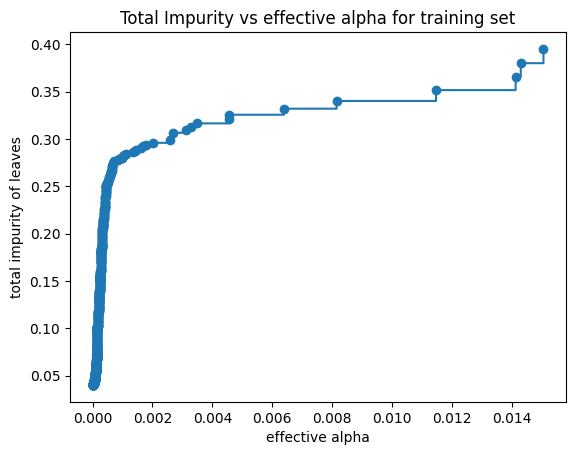

In [114]:
#m = gs.cv_results_["params"][gs.best_index_]['model']
#path = m.cost_complexity_pruning_path(pipe[:-1].fit_transform(X_train), y_train)

m = gs.best_estimator_

X_train_t = m[:-1].fit_transform(X_train)

path = m[-1].cost_complexity_pruning_path(X_train_t, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]

fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [116]:
from tqdm.auto import tqdm

clfs = [DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha).fit(X_train_t, y_train) for ccp_alpha in tqdm(ccp_alphas)]


  0%|          | 0/560 [00:00<?, ?it/s]

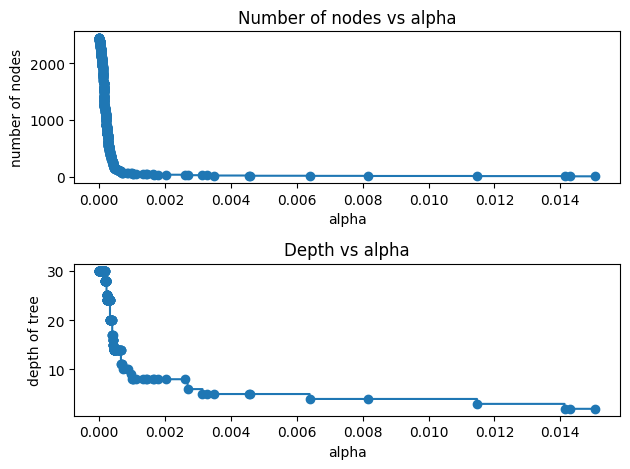

In [117]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [124]:
len(clfs)

560

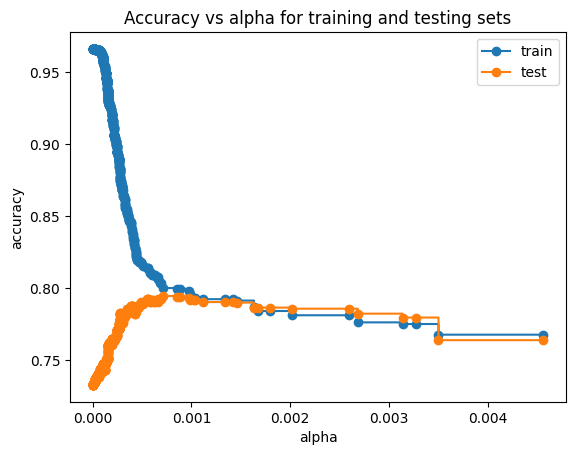

In [130]:
X_test_t =  m[:-1].transform(X_test)

xmax = -7

train_scores = [clf.score(X_train_t, y_train) for clf in clfs]
test_scores = [clf.score(X_test_t, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:xmax], train_scores[:xmax], marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:xmax], test_scores[:xmax], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

AUC scores for GridSearch's best estimator in train and test data :

In [58]:
from sklearn.metrics import roc_auc_score

gs_model = gs.best_estimator_

roc_auc_score(y_train, gs_model.predict(X_train)), roc_auc_score(y_test, gs_model.predict(X_test))

(0.8413774406985758, 0.8068181015920082)

# Predict Test Data

TODO